In [1]:
import numpy as np
import pandas as pd
from scipy.sparse import csr_array
from scipy.sparse.linalg import svds
from time import time
from tqdm import tqdm, trange

from sklearn.metrics import confusion_matrix, r2_score
from sklearn.model_selection import train_test_split

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

# Optimization for Data Science: Final project
## Frank-Wolfe methods for Recommender Systems
### Maksim Kokot (ID: 2072065)

In [36]:
DATA_PATH = 'data/ratings.csv'

BETA = 1e4
N_ITER = 2000
FW_GAMMAS = [*map(lambda x: 2 / (2 + x) * 0.2, range(N_ITER))]
PG_S = .5 * np.ones(N_ITER)
PG_ALPHAS = .5 * np.ones(N_ITER)

In [3]:
def visualize_results(train_losses, val_losses, r2s_train,
                      r2s_val, times, algo_name='Frank Wolfe'):

    '''
    plots validation curves
    '''

    fig, axes = plt.subplots(2, 2, figsize=(10, 10))

    axes[0][0].plot(train_losses, label='train')
    axes[0][0].plot(val_losses, label='validation')
    axes[0][0].legend()
    axes[0][0].grid()
    axes[0][0].set_xlabel('Iteration')
    axes[0][0].set_ylabel('Loss value')
    axes[0][0].set_title('%s. Loss vs iterations' % algo_name)

    axes[0][1].plot(r2s_train, label='train')
    axes[0][1].plot(r2s_val, label='validation')
    axes[0][1].legend()
    axes[0][1].grid()
    axes[0][1].set_xlabel('Iteration')
    axes[0][1].set_ylabel('R2')
    axes[0][1].set_title('%s. R2 vs iterations' % algo_name)

    axes[1][0].plot(times, train_losses, label='train')
    axes[1][0].plot(times, val_losses, label='validation')
    axes[1][0].legend()
    axes[1][0].grid()
    axes[1][0].set_xlabel('Time')
    axes[1][0].set_ylabel('Loss value')
    axes[1][0].set_title('%s. Loss vs time' % algo_name)

    axes[1][1].plot(times, r2s_train, label='train')
    axes[1][1].plot(times, r2s_val, label='validation')
    axes[1][1].legend()
    axes[1][1].grid()
    axes[1][1].set_xlabel('Time')
    axes[1][1].set_ylabel('R2')
    axes[1][1].set_title('%s. R2 vs time' % algo_name)

    plt.show()


def plot_confusion_matrix(true, preds, unique_ratings,
                          algo_name='Frank-Wolfe',
                          part='train'):
    '''
    plots confusion matrix
    '''
    # only integer targets are acceptable
    cm = confusion_matrix((true * 10).astype(int), (preds * 10).astype(int))
    df_cm = pd.DataFrame(cm, index=unique_ratings,
                         columns=unique_ratings)

    plt.figure(figsize=(10, 7))
    sns.heatmap(df_cm, annot=True, fmt='d')
    plt.title('%s. Confusion matrix for %s predictions' % (algo_name, part))
    plt.show()


def compare_results(fw_train_losses, pg_train_losses,
                    fw_time, pg_time):
    '''
    plots results of both algorithms
    '''
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].plot(fw_train_losses, label='Frank-Wolfe')
    axes[0].plot(pg_train_losses, label='Projected gradient')
    axes[0].legend()
    axes[0].grid()
    axes[0].set_xlabel('Iteration')
    axes[0].set_ylabel('Loss value')
    axes[0].set_title('Loss values vs iterations')

    axes[1].plot(fw_time, fw_train_losses, label='Frank Wolfe')
    axes[1].plot(pg_time, pg_train_losses, label='Projected gradient')
    axes[1].legend()
    axes[1].grid()
    axes[1].set_xlabel('Time')
    axes[1].set_ylabel('Loss value')
    axes[1].set_title('Loss values vs time')
    plt.show()

In [4]:
def make_sparse_data(values, rows, cols, shape):
    '''
    makes sparse matrix
    '''
    sparse_data = csr_array((values, (rows, cols)), shape=shape)
    return sparse_data

In [5]:
# initial point

def generate_normalized_vector(size):
    '''
    generates vector with L2-norm = 1
    '''
    vec = np.random.normal(size=size)
    vec = vec / np.linalg.norm(vec)
    return vec


def generate_extreme_point(n_row, n_col, beta=1):
    '''
    generates extreme point
    '''
    u = generate_normalized_vector(n_row)
    v = generate_normalized_vector(n_col)
    p = beta * np.outer(u, v)
    return p


def generate_initial_point(n_row, n_col, betta=1):
    '''
    generates random matrix with nuclear norm <= betta
    as a convex combination of two extreme points
    '''
    p_1 = generate_extreme_point(n_row, n_col, betta)
    p_2 = generate_extreme_point(n_row, n_col, betta)
    gamma = np.random.random()
    initial_point = gamma * p_1 + (1 - gamma) * p_2
    return initial_point

In [6]:
def _find_new_point(y, beta=1):
    '''
    Calculates w_t
    '''
    u, s, vt = svds(-y, k=1, which='LM', solver='arpack')
    return np.outer(u, vt) * beta


def _move_to_next_iterate(x_t, w_t, gamma):
    x_t_plus_1 = x_t + gamma * (w_t - x_t)
    return x_t_plus_1


def _fw_iter(x_t, train_true_sparse, train_preds_sparse, beta, gamma):
    '''
    Frank-Wolfe iteration
    '''
    train_diff = train_true_sparse - train_preds_sparse
    train_loss = (train_diff ** 2).sum()
    grad = - 2 * train_diff
    w_t = _find_new_point(grad, beta)
    x_t_plus_1 = _move_to_next_iterate(x_t, w_t, gamma)
    return x_t_plus_1, train_loss


def _eval_train(true, preds):
    '''
    evaluates train preds
    '''
    r2_train = r2_score(true, preds)
    return r2_train


def _eval_validation(true, preds):
    '''
    evaluates validation preds
    '''
    r2_val = r2_score(true, preds)
    val_loss = ((true - preds) ** 2).sum()
    return r2_val, val_loss


def FW(x_init, train_ratings, train_rows, train_cols,
       val_ratings, val_rows, val_cols, n_iter, gammas,
       beta=1):
    '''
    Frank-Wolfe implementation for matrix completion
    '''
    train_losses = []
    train_r2s = []
    val_losses = []
    val_r2s = []
    acc_time = []
    last_time = 0
    x_t = x_init.copy()
    m_shape = x_t.shape

    train_true_sparse = make_sparse_data(train_ratings,
                                         train_rows,
                                         train_cols,
                                         m_shape)

    tqdm_range = trange(n_iter, desc='Bar desc', leave=True)
    for i in tqdm_range:

        t1 = time()
        gamma = gammas[i]
        train_preds = x_t[train_rows, train_cols]
        val_preds = x_t[val_rows, val_cols]
        train_preds_sparse = make_sparse_data(train_preds,
                                              train_rows,
                                              train_cols,
                                              m_shape)

        r2_train = _eval_train(train_ratings, train_preds)
        r2_val, val_loss = _eval_validation(val_ratings, val_preds)

        x_t, train_loss = _fw_iter(x_t,
                                   train_true_sparse,
                                   train_preds_sparse,
                                   beta, gamma)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_r2s.append(r2_train)
        val_r2s.append(r2_val)

        t2 = time()

        time_diff = (t2 - t1) * 1000
        acc_time.append(time_diff + last_time)
        last_time += time_diff

        tqdm_range.set_description("Epoch %i, Train Loss %f, Val Loss %f)" %
                                   (i, train_loss, val_loss))
        tqdm_range.refresh()

    return x_t, train_losses, val_losses, train_r2s, val_r2s, acc_time

In [7]:
def projection_simplex(point, a=1):
    '''
    Claculates projection onto simplex
    '''
    if np.sum(point) == a:
        return point
    
    v = point[0:1]
    v_p = np.array([])
    rho = point[0] - a
    N = point.shape[0]

    for n in range(1, N):
        point_n = point[n]
        if point_n > rho:
            rho = rho + (point_n - rho) / (len(v) + 1)
            if rho > point_n - a:
                v = np.append(v, point_n)
            else:
                v_p = np.append(v_p, v)
                v = np.array([point_n])
                rho = point_n - a

    if len(v_p):
        for point_y in v_p:
            if point_y > rho:
                v = np.append(v, point_y)
                rho = rho + (point_y - rho) / len(v)

    len_v = len(v)
    new_len_v = -np.inf

    while len_v != new_len_v:
        len_v = len(v)

        for point_y in v:
            if point_y <= rho:
                v = np.delete(v, point_y)
                rho = rho + (rho - point_y) / len(v)
        
        new_len_v = len(v)

    return np.maximum(point-rho, 0)

In [8]:
def _find_projection(w_t, beta=1):
    '''
    Calculates projection onto nuclear norm-ball
    '''
    u, sigma, vh = np.linalg.svd(w_t, full_matrices=False)
    sigma_p = projection_simplex(sigma, beta)
    return u.dot(np.diag(sigma_p).dot(vh))


def _pg_iter(x_t, train_true_sparse, train_preds_sparse, beta, s, alpha):
    '''
    Projected Gradient iteration
    '''
    train_diff = train_true_sparse - train_preds_sparse
    train_loss = (train_diff ** 2).sum()
    grad = - 2 * train_diff
    w_t = x_t - s * grad
    pv_t = _find_projection(w_t, beta)
    x_t_plus_1 = x_t + alpha * (pv_t - x_t)
    return x_t_plus_1, train_loss


def PG(x_init, train_ratings, train_rows, train_cols,
       val_ratings, val_rows, val_cols, n_iter, s_s,
       alphas, beta=1):
    '''
    Projected Gradient implementation for matrix completion
    '''
    train_losses = []
    train_r2s = []
    val_losses = []
    val_r2s = []
    acc_time = []
    last_time = 0
    x_t = x_init.copy()
    m_shape = x_t.shape

    train_true_sparse = make_sparse_data(train_ratings,
                                         train_rows,
                                         train_cols, m_shape)

    tqdm_range = trange(n_iter, desc='Bar desc', leave=True)

    for i in tqdm_range:

        t1 = time()

        alpha = alphas[i]
        s = s_s[i]
        train_preds = x_t[train_rows, train_cols]
        val_preds = x_t[val_rows, val_cols]
        train_preds_sparse = make_sparse_data(train_preds,
                                              train_rows,
                                              train_cols,
                                              m_shape)

        r2_train = _eval_train(train_ratings, train_preds)
        r2_val, val_loss = _eval_validation(val_ratings, val_preds)

        x_t, train_loss = _pg_iter(x_t,
                                   train_true_sparse,
                                   train_preds_sparse,
                                   beta, s, alpha)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_r2s.append(r2_train)
        val_r2s.append(r2_val)

        t2 = time()

        time_diff = (t2 - t1) * 1000
        acc_time.append(time_diff + last_time)
        last_time += time_diff

        tqdm_range.set_description("Epoch %i, Train Loss %f, Val Loss %f)" %
                                   (i, train_loss, val_loss))
        tqdm_range.refresh()

    return x_t, train_losses, val_losses, train_r2s, val_r2s, acc_time

In [9]:
def process_predictions(preds):
    '''
    clips and rounds the preds
    '''
    processed_preds = np.round(preds * 2) / 2
    processed_preds[processed_preds < 0.5] = 0.5
    processed_preds[processed_preds > 5] = 5
    return processed_preds

In [22]:
def compare_iter_cost(ratings_train, row_train, col_train, mat_shape, beta,
                      pg_s, pg_alpha, fw_gamma):
    '''
    compares iteration cost for both algorithms
    '''
    pg_times = []
    fw_times = []
    pg_std = np.array([])
    fw_std = np.array([])
    nums_entries = []
    len_entries = mat_shape[0] * mat_shape[1]
    mat_proportion = mat_shape[1] / mat_shape[0]
    coefs = [*range(1, 11)]

    x_init = generate_initial_point(mat_shape[0], mat_shape[1], beta)
    train_preds = x_init[row_train, col_train]

    train_true_sparse = make_sparse_data(ratings_train,
                                         row_train,
                                         col_train, mat_shape)

    train_preds_sparse = make_sparse_data(train_preds,
                                          row_train,
                                          col_train,
                                          mat_shape)

    for coef in coefs:

        entries_cut = len_entries * coef // 10
        row_cut = int(np.round(np.sqrt(entries_cut / mat_proportion)))
        col_cut = int(np.round(entries_cut / row_cut))
        num_entries = row_cut * col_cut
        nums_entries.append(num_entries)

        x_init_cut = x_init[:row_cut, :col_cut]
        train_true_sparse_cut = train_true_sparse[:row_cut, :col_cut]
        train_preds_sparse_cut = train_preds_sparse[:row_cut, :col_cut]

        fw_iter_times = []
        pg_iter_times = []

        for i in range(5):

            t1 = time()
            _, _ = _pg_iter(x_init_cut,
                            train_true_sparse_cut,
                            train_preds_sparse_cut,
                            beta=beta, s=pg_s, alpha=pg_alpha)
            t2 = time()
            time_diff = (t2 - t1) * 1000
            pg_iter_times.append(time_diff)

            t1 = time()
            _, _ = _fw_iter(x_init_cut,
                            train_true_sparse_cut,
                            train_preds_sparse_cut,
                            beta=beta, gamma=fw_gamma)
            t2 = time()
            time_diff = (t2 - t1) * 1000
            fw_iter_times.append(time_diff)

        fw_times.append(np.mean(fw_iter_times))
        pg_times.append(np.mean(pg_iter_times))
        fw_std = np.append(fw_std, np.std(fw_iter_times))
        pg_std = np.append(pg_std, np.std(pg_iter_times))

    plt.figure(figsize=(7, 7))
    plt.plot(nums_entries, fw_times, color='#1B2ACC',
             label='Frank-Wolfe')
    plt.fill_between(nums_entries, fw_times-fw_std, fw_times+fw_std,
                     alpha=0.2, edgecolor='#1B2ACC', facecolor='#089FFF')

    plt.plot(nums_entries, pg_times, color='#CC4F1B',
             label='Projected Gradient')
    plt.fill_between(nums_entries, pg_times-pg_std, pg_times+pg_std,
                     alpha=0.2, edgecolor='#CC4F1B', facecolor='#FF9848')

    plt.xlabel('Number of entries')
    plt.ylabel('CPU time (ms)')
    plt.legend()
    plt.grid()
    plt.show()

## Read and prepare data

In [37]:
data = pd.read_csv(DATA_PATH,
                   names=['user_id', 'movie_id', 'rating', 'time'],
                   header=0)

In [12]:
# remap user and movie ids into indices 

unique_user_ids = np.sort(data['user_id'].unique())
user_mapping = {id_: num for num, id_ in enumerate(unique_user_ids)}

unique_movie_ids = np.sort(data['movie_id'].unique())
movie_mapping = {id_: num for num, id_ in enumerate(unique_movie_ids)}

rows = data['user_id'].map(user_mapping).values
cols = data['movie_id'].map(movie_mapping).values

In [13]:
# extract rating info

unique_ratings = np.sort(data['rating'].unique())
ratings = data['rating'].values

In [14]:
# train test split

row_train, row_test, col_train, col_test, \
    ratings_train, ratings_test = train_test_split(rows, cols,
                                                   ratings,
                                                   random_state=23)

In [15]:
# rating sparse matrix shape

mat_shape = (len(unique_user_ids), len(unique_movie_ids))

In [16]:
# create initial point

x_init = generate_initial_point(mat_shape[0], mat_shape[1], BETA)

## Frank-Wolfe algorithm

In [17]:
fw_preds, fw_train_losses, fw_val_losses, \
    fw_r2s_train, fw_r2s_val, fw_time = FW(x_init, ratings_train,
                                           row_train, col_train,
                                           ratings_test, row_test,
                                           col_test, n_iter=N_ITER,
                                           gammas=FW_GAMMAS, beta=BETA)

Epoch 1999, Train Loss 2072.906869, Val Loss 40693.606040): 100%|██████████| 2000/2000 [05:50<00:00,  5.71it/s]


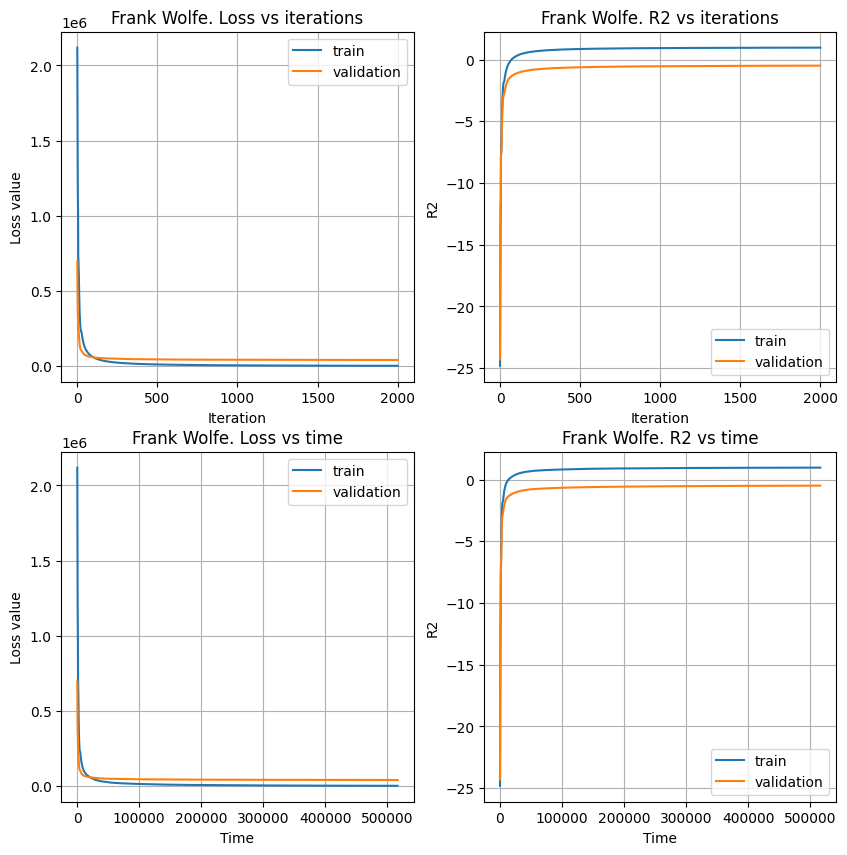

In [74]:
visualize_results(fw_train_losses, fw_val_losses, fw_r2s_train, 
                  fw_r2s_val, fw_time, algo_name='Frank Wolfe')

In [75]:
prosessed_fw_preds = process_predictions(fw_preds)
train_prosessed_fw_preds = prosessed_fw_preds[row_train, col_train]
test_prosessed_fw_preds = prosessed_fw_preds[row_test, col_test]

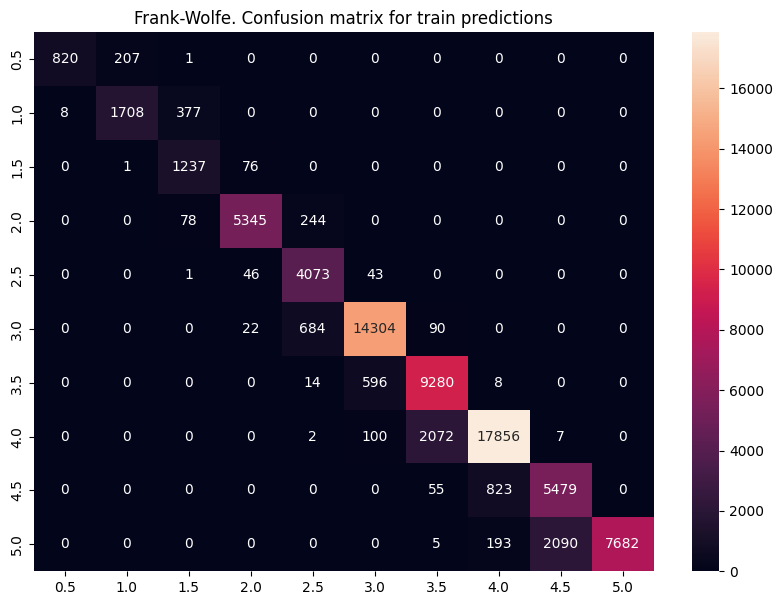

In [76]:
plot_confusion_matrix(ratings_train, train_prosessed_fw_preds, unique_ratings, 
                      algo_name='Frank-Wolfe', part='train')

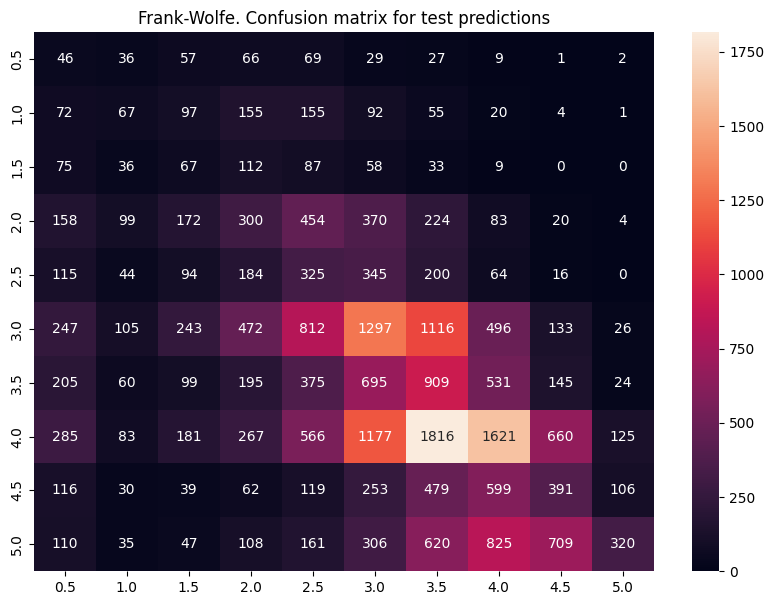

In [77]:
plot_confusion_matrix(ratings_test, test_prosessed_fw_preds, unique_ratings, 
                      algo_name='Frank-Wolfe', part='test')

In [78]:
r2_score(ratings_train, train_prosessed_fw_preds)

0.9724128836187439

In [79]:
r2_score(ratings_test, test_prosessed_fw_preds)

-0.37473133165460104

## Projecred Gradient algorithm

In [32]:
pg_preds, pg_train_losses, pg_val_losses, \
    pg_r2s_train, pg_r2s_val, pg_time = PG(x_init, ratings_train,
                                           row_train, col_train,
                                           ratings_test, row_test, col_test,
                                           n_iter=N_ITER, s_s=PG_S,
                                           alphas=PG_ALPHAS, beta=BETA)

Epoch 1999, Train Loss 480.347012, Val Loss 44622.882129): 100%|█████████████████| 2000/2000 [2:13:25<00:00,  4.00s/it]


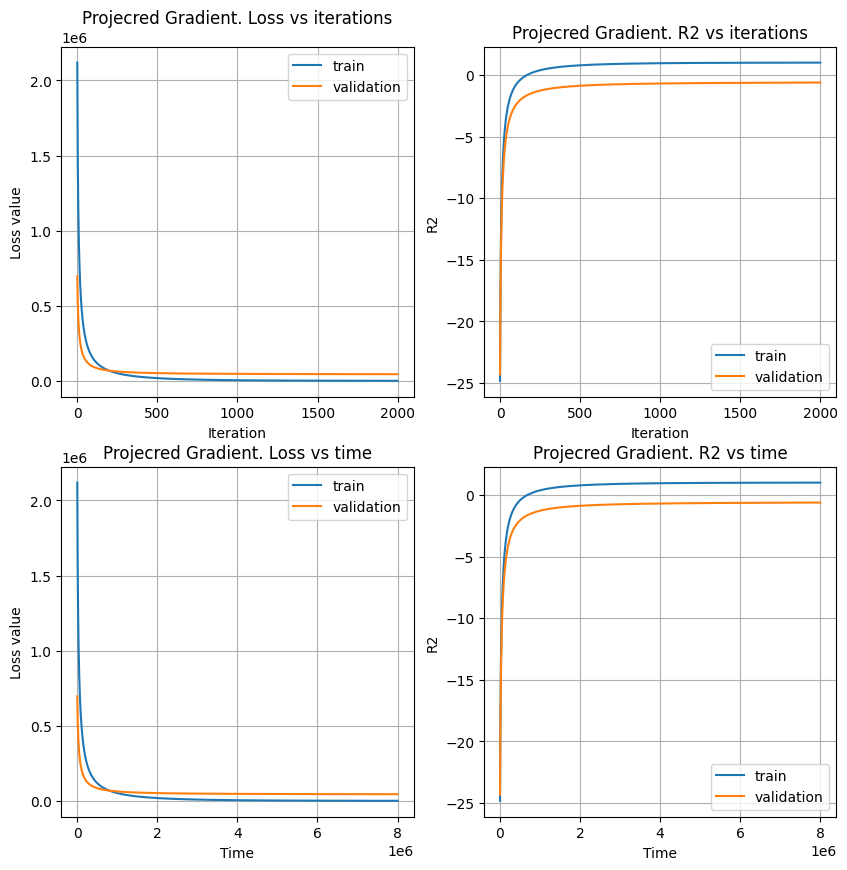

In [46]:
visualize_results(pg_train_losses, pg_val_losses, pg_r2s_train, 
                  pg_r2s_val, pg_time, algo_name='Projecred Gradient')

In [47]:
prosessed_pg_preds = process_predictions(pg_preds)
train_prosessed_pg_preds = prosessed_pg_preds[row_train, col_train]
test_prosessed_pg_preds = prosessed_pg_preds[row_test, col_test]

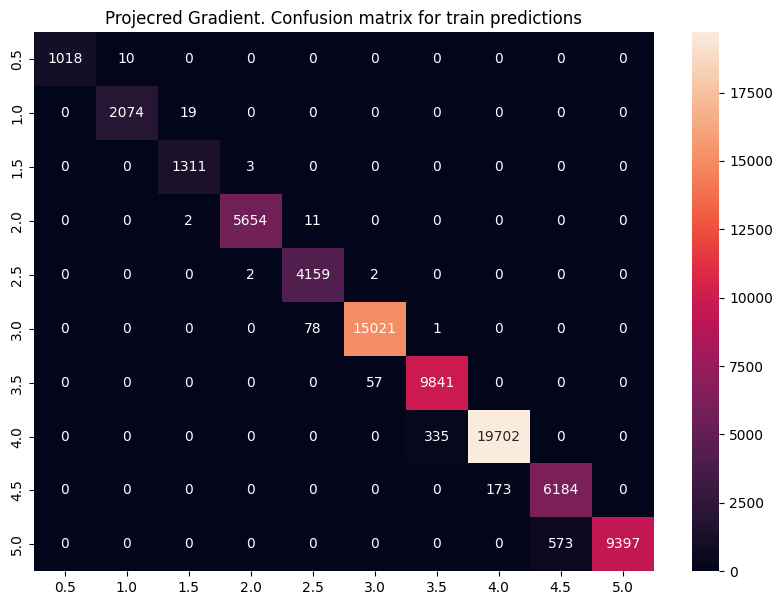

In [48]:
plot_confusion_matrix(ratings_train, train_prosessed_pg_preds, unique_ratings, 
                      algo_name='Projecred Gradient', part='train')

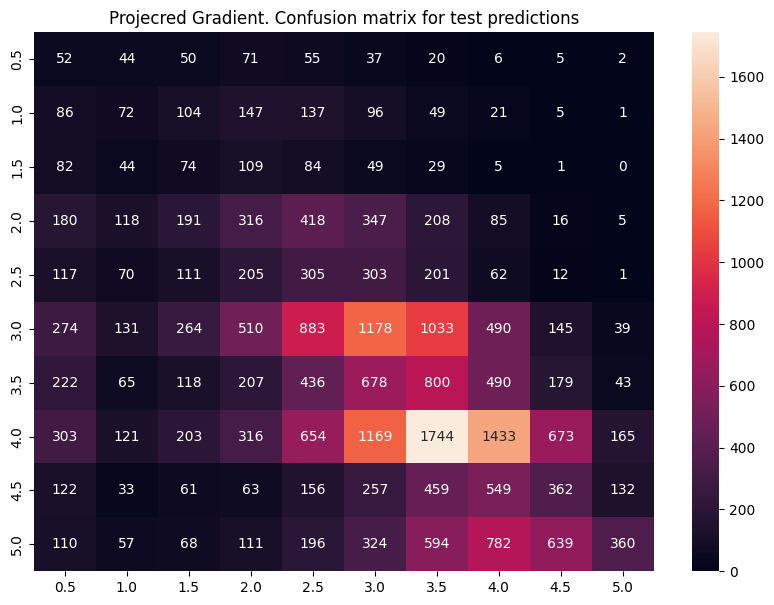

In [49]:
plot_confusion_matrix(ratings_test, test_prosessed_pg_preds, unique_ratings, 
                      algo_name='Projecred Gradient', part='test')

In [50]:
r2_score(ratings_train, train_prosessed_pg_preds)

0.9961438346760881

In [51]:
r2_score(ratings_test, test_prosessed_pg_preds)

-0.48963902196750086

## Compare the algorithms

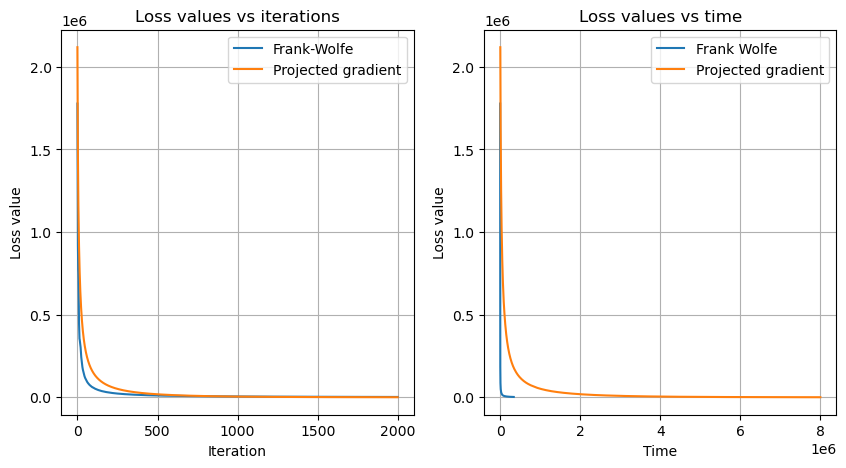

In [20]:
compare_results(fw_train_losses, pg_train_losses,
                    fw_time, pg_time)

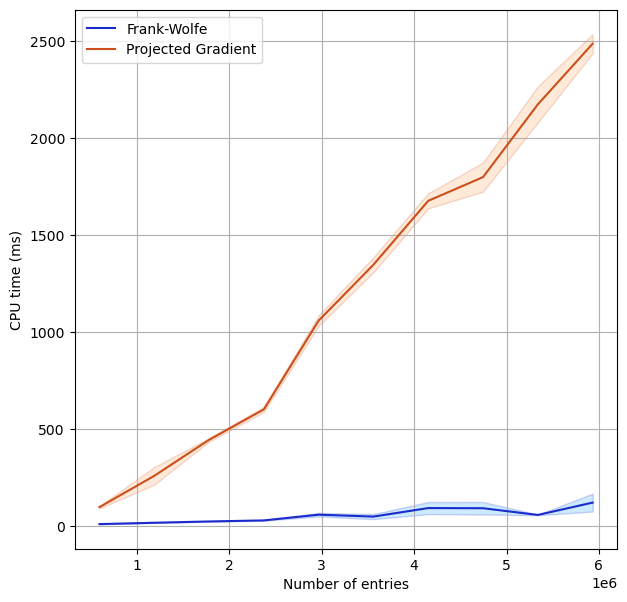

In [24]:
compare_iter_cost(ratings_train, row_train, col_train, mat_shape, 
                  BETA, PG_S[0], PG_ALPHAS[0], FW_GAMMAS[0])